# Estimate scavenging rates from observations

Dissolved trace metal data from Manuel Colombo, particulate trace metal data from Jingxuan Li.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
import seaborn as sns; sns.set()
import netCDF4 as nc
from matplotlib.ticker import FormatStrFormatter
import datetime as dt

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

##### Load files:

In [3]:
# Dissolved trace metal observations
Pb_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')

dPb_BB1 = Pb_data['BB1'][np.isfinite(Pb_data['BB1'])].astype('float')
dPb_BB2 = Pb_data['BB2'][np.isfinite(Pb_data['BB2'])].astype('float')
dPb_BB3 = Pb_data['BB3'][np.isfinite(Pb_data['BB3'])].astype('float')
dPb_CB1 = Pb_data['CB1'][np.isfinite(Pb_data['CB1'])].astype('float')
dPb_CB2 = Pb_data['CB2'][np.isfinite(Pb_data['CB2'])].astype('float')
dPb_CB3 = Pb_data['CB3'][np.isfinite(Pb_data['CB3'])].astype('float')
dPb_CB4 = Pb_data['CB4'][np.isfinite(Pb_data['CB4'])].astype('float')
dPb_CAA1 = Pb_data['CAA1'][np.isfinite(Pb_data['CAA1'])].astype('float')
dPb_CAA2 = Pb_data['CAA2'][np.isfinite(Pb_data['CAA2'])].astype('float')
dPb_CAA3 = Pb_data['CAA3'][np.isfinite(Pb_data['CAA3'])].astype('float')
dPb_CAA4 = Pb_data['CAA4'][np.isfinite(Pb_data['CAA4'])].astype('float')
dPb_CAA5 = Pb_data['CAA5'][np.isfinite(Pb_data['CAA5'])].astype('float')
dPb_CAA6 = Pb_data['CAA6'][np.isfinite(Pb_data['CAA6'])].astype('float')
dPb_CAA7 = Pb_data['CAA7'][np.isfinite(Pb_data['CAA7'])].astype('float')
dPb_CAA8 = Pb_data['CAA8'][np.isfinite(Pb_data['CAA8'])].astype('float')
dPb_CAA9 = Pb_data['CAA9'][np.isfinite(Pb_data['CAA9'])].astype('float')

depth_BB1 = Pb_data['Depth.1'][np.isfinite(Pb_data['BB1'])].astype('float')
depth_BB2 = Pb_data['Depth.2'][np.isfinite(Pb_data['BB2'])].astype('float')
depth_BB3 = Pb_data['Depth.3'][np.isfinite(Pb_data['BB3'])].astype('float')
depth_CB1 = Pb_data['Depth.13'][np.isfinite(Pb_data['CB1'])].astype('float')
depth_CB2 = Pb_data['Depth.14'][np.isfinite(Pb_data['CB2'])].astype('float')
depth_CB3 = Pb_data['Depth.15'][np.isfinite(Pb_data['CB3'])].astype('float')
depth_CB4 = Pb_data['Depth.16'][np.isfinite(Pb_data['CB4'])].astype('float')
depth_CAA1 = Pb_data['Depth.4'][np.isfinite(Pb_data['CAA1'])].astype('float')
depth_CAA2 = Pb_data['Depth.5'][np.isfinite(Pb_data['CAA2'])].astype('float')
depth_CAA3 = Pb_data['Depth.6'][np.isfinite(Pb_data['CAA3'])].astype('float')
depth_CAA4 = Pb_data['Depth.7'][np.isfinite(Pb_data['CAA4'])].astype('float')
depth_CAA5 = Pb_data['Depth.8'][np.isfinite(Pb_data['CAA5'])].astype('float')
depth_CAA6 = Pb_data['Depth.9'][np.isfinite(Pb_data['CAA6'])].astype('float')
depth_CAA7 = Pb_data['Depth.10'][np.isfinite(Pb_data['CAA7'])].astype('float')
depth_CAA8 = Pb_data['Depth.11'][np.isfinite(Pb_data['CAA8'])].astype('float')
depth_CAA9 = Pb_data['Depth.12'][np.isfinite(Pb_data['CAA9'])].astype('float')

In [4]:
stn_names = Pb_data['Station names'].dropna().astype('str')
lons = Pb_data['station lon'].astype('float').dropna().values
lats = Pb_data['Station lat'].astype('float').dropna().values

In [5]:
# Particulate trace metal observations:
p_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/pTM_Maldonado_DATA_v2_notes.csv')

stns = p_data['GEOTR_STN'].astype('str')
pPb_BB1 = p_data['Pb (pmol/L)'].where(stns == 'BB1').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_BB2 = p_data['Pb (pmol/L)'].where(stns == 'BB2').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_BB3 = p_data['Pb (pmol/L)'].where(stns == 'BB3').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CB1 = p_data['Pb (pmol/L)'].where(stns == 'CB1').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CB2 = p_data['Pb (pmol/L)'].where(stns == 'CB2').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CB3 = p_data['Pb (pmol/L)'].where(stns == 'CB3').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CB4 = p_data['Pb (pmol/L)'].where(stns == 'CB4').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CAA1 = p_data['Pb (pmol/L)'].where(stns == 'CAA1').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CAA2 = p_data['Pb (pmol/L)'].where(stns == 'CAA2').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CAA3 = p_data['Pb (pmol/L)'].where(stns == 'CAA3').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CAA4 = p_data['Pb (pmol/L)'].where(stns == 'CAA4').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CAA5 = p_data['Pb (pmol/L)'].where(stns == 'CAA5').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CAA6 = p_data['Pb (pmol/L)'].where(stns == 'CAA6').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CAA7 = p_data['Pb (pmol/L)'].where(stns == 'CAA7').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CAA8 = p_data['Pb (pmol/L)'].where(stns == 'CAA8').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CAA9 = p_data['Pb (pmol/L)'].where(stns == 'CAA9').apply(pd.to_numeric, errors='coerce').dropna().astype('float')

pd_BB1     = p_data['CTDPRS (DBAR)'].where(stns == 'BB1').dropna().astype('float')
pdepth_BB1 = [pd_BB1[i] for i in pPb_BB1.index.values]
pd_BB2     = p_data['CTDPRS (DBAR)'].where(stns == 'BB2').dropna().astype('float')
pdepth_BB2 = [pd_BB2[i] for i in pPb_BB2.index.values]
pd_BB3     = p_data['CTDPRS (DBAR)'].where(stns == 'BB3').dropna().astype('float')
pdepth_BB3 = [pd_BB3[i] for i in pPb_BB3.index.values]

pd_CB1     = p_data['CTDPRS (DBAR)'].where(stns == 'CB1').dropna().astype('float')
pdepth_CB1 = [pd_CB1[i] for i in pPb_CB1.index.values]
pd_CB2     = p_data['CTDPRS (DBAR)'].where(stns == 'CB2').dropna().astype('float')
pdepth_CB2 = [pd_CB2[i] for i in pPb_CB2.index.values]
pd_CB3     = p_data['CTDPRS (DBAR)'].where(stns == 'CB3').dropna().astype('float')
pdepth_CB3 = [pd_CB3[i] for i in pPb_CB3.index.values]
pd_CB4     = p_data['CTDPRS (DBAR)'].where(stns == 'CB4').dropna().astype('float')
pdepth_CB4 = [pd_CB4[i] for i in pPb_CB4.index.values]

pd_CAA1     = p_data['CTDPRS (DBAR)'].where(stns == 'CAA1').dropna().astype('float')
pdepth_CAA1 = [pd_CAA1[i] for i in pPb_CAA1.index.values]
pd_CAA2     = p_data['CTDPRS (DBAR)'].where(stns == 'CAA2').dropna().astype('float')
pdepth_CAA2 = [pd_CAA2[i] for i in pPb_CAA2.index.values]
pd_CAA3     = p_data['CTDPRS (DBAR)'].where(stns == 'CAA3').dropna().astype('float')
pdepth_CAA3 = [pd_CAA3[i] for i in pPb_CAA3.index.values]
pd_CAA4     = p_data['CTDPRS (DBAR)'].where(stns == 'CAA4').dropna().astype('float')
pdepth_CAA4 = [pd_CAA4[i] for i in pPb_CAA4.index.values]
pd_CAA5     = p_data['CTDPRS (DBAR)'].where(stns == 'CAA5').dropna().astype('float')
pdepth_CAA5 = [pd_CAA5[i] for i in pPb_CAA5.index.values]
pd_CAA6     = p_data['CTDPRS (DBAR)'].where(stns == 'CAA6').dropna().astype('float')
pdepth_CAA6 = [pd_CAA6[i] for i in pPb_CAA6.index.values]
pd_CAA7     = p_data['CTDPRS (DBAR)'].where(stns == 'CAA7').dropna().astype('float')
pdepth_CAA7 = [pd_CAA7[i] for i in pPb_CAA7.index.values]
pd_CAA8     = p_data['CTDPRS (DBAR)'].where(stns == 'CAA8').dropna().astype('float')
pdepth_CAA8 = [pd_CAA8[i] for i in pPb_CAA8.index.values]
pd_CAA9     = p_data['CTDPRS (DBAR)'].where(stns == 'CAA9').dropna().astype('float')
pdepth_CAA9 = [pd_CAA9[i] for i in pPb_CAA9.index.values]

In [6]:
depths = np.concatenate((depth_BB1, depth_BB2, depth_BB3, depth_CAA1, depth_CAA2, depth_CAA3, depth_CAA4, \
                         depth_CAA5, depth_CAA6, depth_CAA7, depth_CAA8, depth_CAA9, depth_CB1, depth_CB2, \
                         depth_CB3, depth_CB4))

In [7]:
obs_lons = np.concatenate((np.ones(depth_BB1.shape)*lons[stn_names=='BB1'], \
                          np.ones(depth_BB2.shape)*lons[stn_names=='BB2'], \
                          np.ones(depth_BB3.shape)*lons[stn_names=='BB3'], \
                          np.ones(depth_CAA1.shape)*lons[stn_names=='CAA1'], \
                          np.ones(depth_CAA2.shape)*lons[stn_names=='CAA2'], \
                          np.ones(depth_CAA3.shape)*lons[stn_names=='CAA3'], \
                          np.ones(depth_CAA4.shape)*lons[stn_names=='CAA4'], \
                          np.ones(depth_CAA5.shape)*lons[stn_names=='CAA5'], \
                          np.ones(depth_CAA6.shape)*lons[stn_names=='CAA6'], \
                          np.ones(depth_CAA7.shape)*lons[stn_names=='CAA7'], \
                          np.ones(depth_CAA8.shape)*lons[stn_names=='CAA8'], \
                          np.ones(depth_CAA9.shape)*lons[stn_names=='CAA9'], \
                          np.ones(depth_CB1.shape)*lons[stn_names=='CB1'], \
                          np.ones(depth_CB2.shape)*lons[stn_names=='CB2'], \
                          np.ones(depth_CB3.shape)*lons[stn_names=='CB3'], \
                          np.ones(depth_CB4.shape)*lons[stn_names=='CB4']))

obs_lats = np.concatenate((np.ones(depth_BB1.shape)*lats[stn_names=='BB1'], \
                          np.ones(depth_BB2.shape)*lats[stn_names=='BB2'], \
                          np.ones(depth_BB3.shape)*lats[stn_names=='BB3'], \
                          np.ones(depth_CAA1.shape)*lats[stn_names=='CAA1'], \
                          np.ones(depth_CAA2.shape)*lats[stn_names=='CAA2'], \
                          np.ones(depth_CAA3.shape)*lats[stn_names=='CAA3'], \
                          np.ones(depth_CAA4.shape)*lats[stn_names=='CAA4'], \
                          np.ones(depth_CAA5.shape)*lats[stn_names=='CAA5'], \
                          np.ones(depth_CAA6.shape)*lats[stn_names=='CAA6'], \
                          np.ones(depth_CAA7.shape)*lats[stn_names=='CAA7'], \
                          np.ones(depth_CAA8.shape)*lats[stn_names=='CAA8'], \
                          np.ones(depth_CAA9.shape)*lats[stn_names=='CAA9'], \
                          np.ones(depth_CB1.shape)*lats[stn_names=='CB1'], \
                          np.ones(depth_CB2.shape)*lats[stn_names=='CB2'], \
                          np.ones(depth_CB3.shape)*lats[stn_names=='CB3'], \
                          np.ones(depth_CB4.shape)*lats[stn_names=='CB4']))

##### Functions:

In [8]:
def assoc_depth(depth_pPb, depth_dPb, pPb_stn, dPb_stn):
    depth_pPb = np.array(depth_pPb)
    depth_dPb = np.array(depth_dPb)
    pPb_stn = np.array(pPb_stn)
    dPb_stn = np.array(dPb_stn)
    
    if len(depth_pPb) > len(depth_dPb):
        depth_list    = depth_pPb
        depth_shorter = depth_dPb
    else:
        depth_list    = depth_dPb
        depth_shorter = depth_pPb

    depths= np.empty_like(depth_list)
    pPb   = np.empty_like(depth_list)
    dPb   = np.empty_like(depth_list)
    i=0
    
    for depth in depth_list:
        if len(depth_shorter) > 0:
            min_val  = np.argmin(np.abs(depth_shorter - depth))
            if np.abs(depth_shorter[min_val] - depth) > 10:
                depths[i] = np.nan
                pPb[i]    = np.nan
                dPb[i]    = np.nan
            else:
                depths[i] = depth_shorter[min_val]
                if len(depth_pPb) > len(depth_dPb):
                    pPb[i]    = pPb_stn[i]
                    dPb[i]    = dPb_stn[min_val]                
                else:
                    pPb[i]    = pPb_stn[min_val]
                    dPb[i]    = dPb_stn[i]
            i+=1
        
    return depths, pPb, dPb

##### Calculations:

In [9]:
depths_CAA1, pPb_CAA1, dPb_CAA1 = assoc_depth(pdepth_CAA1, depth_CAA1, pPb_CAA1, dPb_CAA1)
depths_CAA2, pPb_CAA2, dPb_CAA2 = assoc_depth(pdepth_CAA2, depth_CAA2, pPb_CAA2, dPb_CAA2)
depths_CAA3, pPb_CAA3, dPb_CAA3 = assoc_depth(pdepth_CAA3, depth_CAA3, pPb_CAA3, dPb_CAA3)
depths_CAA4, pPb_CAA4, dPb_CAA4 = assoc_depth(pdepth_CAA4, depth_CAA4, pPb_CAA4, dPb_CAA4)
depths_CAA5, pPb_CAA5, dPb_CAA5 = assoc_depth(pdepth_CAA5, depth_CAA5, pPb_CAA5, dPb_CAA5)
depths_CAA6, pPb_CAA6, dPb_CAA6 = assoc_depth(pdepth_CAA6, depth_CAA6, pPb_CAA6, dPb_CAA6)
depths_CAA7, pPb_CAA7, dPb_CAA7 = assoc_depth(pdepth_CAA7, depth_CAA7, pPb_CAA7, dPb_CAA7)
depths_CAA8, pPb_CAA8, dPb_CAA8 = assoc_depth(pdepth_CAA8, depth_CAA8, pPb_CAA8, dPb_CAA8)
depths_CAA9, pPb_CAA9, dPb_CAA9 = assoc_depth(pdepth_CAA9, depth_CAA9, pPb_CAA9, dPb_CAA9)

depths_CB1, pPb_CB1, dPb_CB1 = assoc_depth(pdepth_CB1, depth_CB1, pPb_CB1, dPb_CB1)
depths_CB2, pPb_CB2, dPb_CB2 = assoc_depth(pdepth_CB2, depth_CB2, pPb_CB2, dPb_CB2)
depths_CB3, pPb_CB3, dPb_CB3 = assoc_depth(pdepth_CB3, depth_CB3, pPb_CB3, dPb_CB3)
depths_CB4, pPb_CB4, dPb_CB4 = assoc_depth(pdepth_CB4, depth_CB4, pPb_CB4, dPb_CB4)

depths_BB1, pPb_BB1, dPb_BB1 = assoc_depth(pdepth_BB1, depth_BB1, pPb_BB1, dPb_BB1)
depths_BB2, pPb_BB2, dPb_BB2 = assoc_depth(pdepth_BB2, depth_BB2, pPb_BB2, dPb_BB2)
depths_BB3, pPb_BB3, dPb_BB3 = assoc_depth(pdepth_BB3, depth_BB3, pPb_BB3, dPb_BB3)

##### Figures:

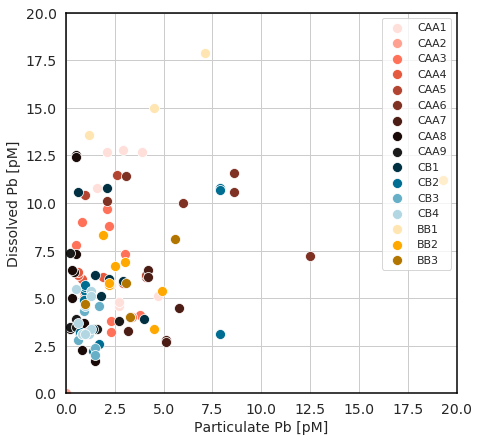

In [32]:
fig = plt.figure(figsize=(7,7))
st = sns.axes_style("whitegrid")

with st:
#     sns.lineplot(xp, yp_pred, color='k')
    ax = sns.scatterplot(pPb_CAA1, dPb_CAA1*1e3, label='CAA1', color='#ffdfda', s=100)
    sns.scatterplot(pPb_CAA2, dPb_CAA2*1e3, label='CAA2', color='#ffa190', s=100)
    sns.scatterplot(pPb_CAA3, dPb_CAA3*1e3, label='CAA3', color='#ff7259', s=100)
    sns.scatterplot(pPb_CAA4, dPb_CAA4*1e3, label='CAA4', color='#e5593f', s=100)
    sns.scatterplot(pPb_CAA5, dPb_CAA5*1e3, label='CAA5', color='#b24531', s=100)
    sns.scatterplot(pPb_CAA6, dPb_CAA6*1e3, label='CAA6', color='#7f3123', s=100)
    sns.scatterplot(pPb_CAA7, dPb_CAA7*1e3, label='CAA7', color='#4c1d15', s=100)
    sns.scatterplot(pPb_CAA8, dPb_CAA8*1e3, label='CAA8', color='#190907', s=100)
    sns.scatterplot(pPb_CAA9, dPb_CAA9*1e3, label='CAA9', color='k', s=100)
    
    sns.scatterplot(pPb_CB1, dPb_CB1*1e3, label='CB1', color='#003041', s=100)
    sns.scatterplot(pPb_CB2, dPb_CB2*1e3, label='CB2', color='#006d92', s=100)
    sns.scatterplot(pPb_CB3, dPb_CB3*1e3, label='CB3', color='#66afc7', s=100)
    sns.scatterplot(pPb_CB4, dPb_CB4*1e3, label='CB4', color='#b2d7e3', s=100)
    
    sns.scatterplot(pPb_BB1, dPb_BB1*1e3, label='BB1', color='#ffe5b2', s=100)
    sns.scatterplot(pPb_BB2, dPb_BB2*1e3, label='BB2', color='#ffa900', s=100)
    sns.scatterplot(pPb_BB3, dPb_BB3*1e3, label='BB3', color='#b27600', s=100)
    
    ax.set_xlabel('Particulate Pb [pM]', fontsize=14)
    ax.set_ylabel('Dissolved Pb [pM]', fontsize=14)
    ax.set(ylim=(0,20.0), xlim=(0,20.0))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

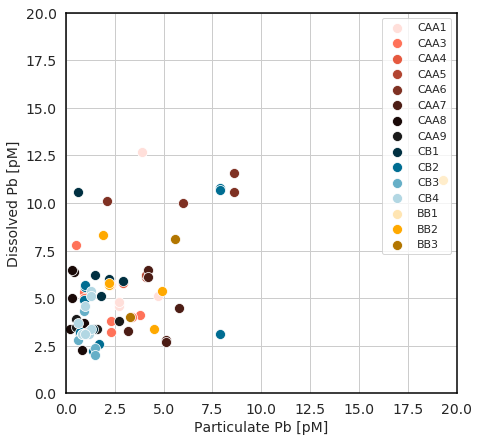

In [33]:
fig = plt.figure(figsize=(7,7))
st = sns.axes_style("whitegrid")

with st:
#     sns.lineplot(xp, yp_pred, color='k')
    ax = sns.scatterplot(pPb_CAA1[depths_CAA1 > 50], dPb_CAA1[depths_CAA1 > 50]*1e3, label='CAA1', color='#ffdfda', s=100)
    sns.scatterplot(pPb_CAA2[depths_CAA2 > 50], dPb_CAA2[depths_CAA2 > 50]*1e3, label='CAA2', color='#ffa190', s=100)
    sns.scatterplot(pPb_CAA3[depths_CAA3 > 50], dPb_CAA3[depths_CAA3 > 50]*1e3, label='CAA3', color='#ff7259', s=100)
    sns.scatterplot(pPb_CAA4[depths_CAA4 > 50], dPb_CAA4[depths_CAA4 > 50]*1e3, label='CAA4', color='#e5593f', s=100)
    sns.scatterplot(pPb_CAA5[depths_CAA5 > 50], dPb_CAA5[depths_CAA5 > 50]*1e3, label='CAA5', color='#b24531', s=100)
    sns.scatterplot(pPb_CAA6[depths_CAA6 > 50], dPb_CAA6[depths_CAA6 > 50]*1e3, label='CAA6', color='#7f3123', s=100)
    sns.scatterplot(pPb_CAA7[depths_CAA7 > 50], dPb_CAA7[depths_CAA7 > 50]*1e3, label='CAA7', color='#4c1d15', s=100)
    sns.scatterplot(pPb_CAA8[depths_CAA8 > 50], dPb_CAA8[depths_CAA8 > 50]*1e3, label='CAA8', color='#190907', s=100)
    sns.scatterplot(pPb_CAA9[depths_CAA9 > 50], dPb_CAA9[depths_CAA9 > 50]*1e3, label='CAA9', color='k', s=100)
    
    sns.scatterplot(pPb_CB1[depths_CB1 > 50], dPb_CB1[depths_CB1 > 50]*1e3, label='CB1', color='#003041', s=100)
    sns.scatterplot(pPb_CB2[depths_CB2 > 50], dPb_CB2[depths_CB2 > 50]*1e3, label='CB2', color='#006d92', s=100)
    sns.scatterplot(pPb_CB3[depths_CB3 > 50], dPb_CB3[depths_CB3 > 50]*1e3, label='CB3', color='#66afc7', s=100)
    sns.scatterplot(pPb_CB4[depths_CB4 > 50], dPb_CB4[depths_CB4 > 50]*1e3, label='CB4', color='#b2d7e3', s=100)
    
    sns.scatterplot(pPb_BB1[depths_BB1 > 50], dPb_BB1[depths_BB1 > 50]*1e3, label='BB1', color='#ffe5b2', s=100)
    sns.scatterplot(pPb_BB2[depths_BB2 > 50], dPb_BB2[depths_BB2 > 50]*1e3, label='BB2', color='#ffa900', s=100)
    sns.scatterplot(pPb_BB3[depths_BB3 > 50], dPb_BB3[depths_BB3 > 50]*1e3, label='BB3', color='#b27600', s=100)
    
    ax.set_xlabel('Particulate Pb [pM]', fontsize=14)
    ax.set_ylabel('Dissolved Pb [pM]', fontsize=14)
    ax.set(ylim=(0,20.0), xlim=(0,20.0))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

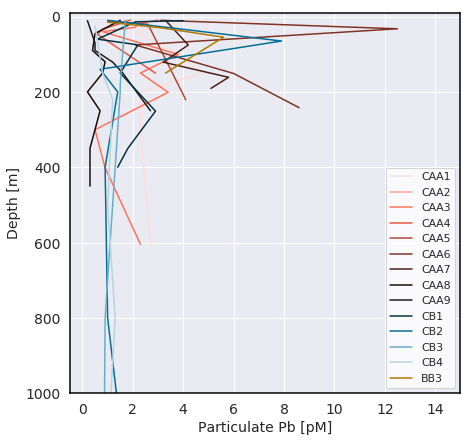

In [61]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
st = sns.axes_style("whitegrid")

with st:
#     ax.plot(xp, yp_pred, color='k')
    ax.plot(pPb_CAA1[~np.isnan(depths_CAA1)], depths_CAA1[~np.isnan(depths_CAA1)], label='CAA1', color='#ffdfda')
    ax.plot(pPb_CAA2[~np.isnan(depths_CAA2)], depths_CAA2[~np.isnan(depths_CAA2)], label='CAA2', color='#ffa190')
    ax.plot(pPb_CAA3[~np.isnan(depths_CAA3)], depths_CAA3[~np.isnan(depths_CAA3)], label='CAA3', color='#ff7259')
    ax.plot(pPb_CAA4[~np.isnan(depths_CAA4)], depths_CAA4[~np.isnan(depths_CAA4)], label='CAA4', color='#e5593f')
    ax.plot(pPb_CAA5[~np.isnan(depths_CAA5)], depths_CAA5[~np.isnan(depths_CAA5)], label='CAA5', color='#b24531')
    ax.plot(pPb_CAA6[~np.isnan(depths_CAA6)], depths_CAA6[~np.isnan(depths_CAA6)], label='CAA6', color='#7f3123')
    ax.plot(pPb_CAA7[~np.isnan(depths_CAA7)], depths_CAA7[~np.isnan(depths_CAA7)], label='CAA7', color='#4c1d15')
    ax.plot(pPb_CAA8[~np.isnan(depths_CAA8)], depths_CAA8[~np.isnan(depths_CAA8)], label='CAA8', color='#190907')
    ax.plot(pPb_CAA9[~np.isnan(depths_CAA9)], depths_CAA9[~np.isnan(depths_CAA9)], label='CAA9', color='k')
    
    ax.plot(pPb_CB1[~np.isnan(depths_CB1)], depths_CB1[~np.isnan(depths_CB1)], label='CB1', color='#003041')
    ax.plot(pPb_CB2[~np.isnan(depths_CB2)], depths_CB2[~np.isnan(depths_CB2)], label='CB2', color='#006d92')
    ax.plot(pPb_CB3[~np.isnan(depths_CB3)], depths_CB3[~np.isnan(depths_CB3)], label='CB3', color='#66afc7')
    ax.plot(pPb_CB4[~np.isnan(depths_CB4)], depths_CB4[~np.isnan(depths_CB4)], label='CB4', color='#b2d7e3')
    
#     ax.plot(pPb_BB1[~np.isnan(depths_BB1)], depths_BB1[~np.isnan(depths_BB1)], label='BB1', color='#ffe5b2')
#     ax.plot(pPb_BB2[~np.isnan(depths_BB2)], depths_BB2[~np.isnan(depths_BB2)], label='BB2', color='#ffa900')
    ax.plot(pPb_BB3[~np.isnan(depths_BB3)], depths_BB3[~np.isnan(depths_BB3)], label='BB3', color='#b27600')
    
    ax.invert_yaxis()
    ax.set_xlabel('Particulate Pb [pM]', fontsize=14)
    ax.set_ylabel('Depth [m]', fontsize=14)
    ax.set(ylim=(1000,-10), xlim=(-0.5,15.0))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');   
    
    ax.legend()

In [121]:
drop_BB1 = np.nanmean(dPb_BB1[depths_BB1 < 50]) - dPb_BB1[depths_BB1 > 50]
drop_BB2 = np.nanmean(dPb_BB2[depths_BB2 < 50]) - dPb_BB2[depths_BB2 > 50]
drop_BB3 = np.nanmean(dPb_BB3[depths_BB3 < 50]) - dPb_BB3[depths_BB3 > 50]
ddep_BB1 = depths_BB1[depths_BB1 > 50]
ddep_BB2 = depths_BB2[depths_BB2 > 50]
ddep_BB3 = depths_BB3[depths_BB3 > 50]

drop_CB1 = np.nanmean(dPb_CB1[depths_CB1 < 50]) - dPb_CB1[depths_CB1 > 50]
drop_CB2 = np.nanmean(dPb_CB2[depths_CB2 < 50]) - dPb_CB2[depths_CB2 > 50]
drop_CB3 = np.nanmean(dPb_CB3[depths_CB3 < 50]) - dPb_CB3[depths_CB3 > 50]
drop_CB4 = np.nanmean(dPb_CB4[depths_CB4 < 50]) - dPb_CB4[depths_CB4 > 50]
ddep_CB1 = depths_CB1[depths_CB1 > 50]
ddep_CB2 = depths_CB2[depths_CB2 > 50]
ddep_CB3 = depths_CB3[depths_CB3 > 50]
ddep_CB4 = depths_CB4[depths_CB4 > 50]

drop_CAA1 = np.nanmean(dPb_CAA1[depths_CAA1 < 50]) - dPb_CAA1[depths_CAA1 > 50]
drop_CAA2 = np.nanmean(dPb_CAA2[depths_CAA2 < 50]) - dPb_CAA2[depths_CAA2 > 50]
drop_CAA3 = np.nanmean(dPb_CAA3[depths_CAA3 < 50]) - dPb_CAA3[depths_CAA3 > 50]
drop_CAA4 = np.nanmean(dPb_CAA4[depths_CAA4 < 50]) - dPb_CAA4[depths_CAA4 > 50]
drop_CAA5 = np.nanmean(dPb_CAA5[depths_CAA5 < 50]) - dPb_CAA5[depths_CAA5 > 50]
drop_CAA6 = np.nanmean(dPb_CAA6[depths_CAA6 < 50]) - dPb_CAA6[depths_CAA6 > 50]
drop_CAA7 = np.nanmean(dPb_CAA7[depths_CAA7 < 50]) - dPb_CAA7[depths_CAA7 > 50]
drop_CAA8 = np.nanmean(dPb_CAA8[depths_CAA8 < 50]) - dPb_CAA8[depths_CAA8 > 50]
drop_CAA9 = np.nanmean(dPb_CAA9[depths_CAA9 < 50]) - dPb_CAA9[depths_CAA9 > 50]
ddep_CAA1 = depths_CAA1[depths_CAA1 > 50]
ddep_CAA2 = depths_CAA2[depths_CAA2 > 50]
ddep_CAA3 = depths_CAA3[depths_CAA3 > 50]
ddep_CAA4 = depths_CAA4[depths_CAA4 > 50]
ddep_CAA5 = depths_CAA5[depths_CAA5 > 50]
ddep_CAA6 = depths_CAA6[depths_CAA6 > 50]
ddep_CAA7 = depths_CAA7[depths_CAA7 > 50]
ddep_CAA8 = depths_CAA8[depths_CAA8 > 50]
ddep_CAA9 = depths_CAA9[depths_CAA9 > 50]

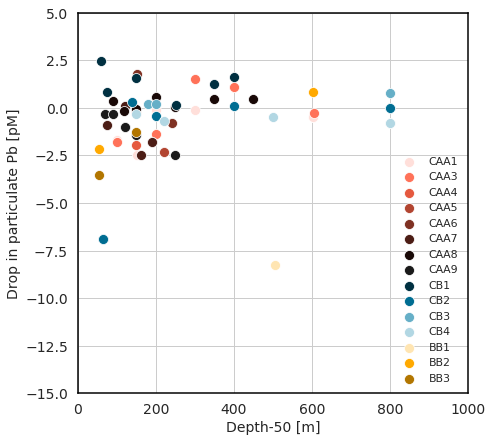

In [109]:
fig = plt.figure(figsize=(7,7))
st = sns.axes_style("whitegrid")

with st:
#     sns.lineplot(xp, yp_pred, color='k')
    ax = sns.scatterplot(ddep_CAA1, drop_CAA1, label='CAA1', color='#ffdfda', s=100)
    sns.scatterplot(ddep_CAA2, drop_CAA2, label='CAA2', color='#ffa190', s=100)
    sns.scatterplot(ddep_CAA3, drop_CAA3, label='CAA3', color='#ff7259', s=100)
    sns.scatterplot(ddep_CAA4, drop_CAA4, label='CAA4', color='#e5593f', s=100)
    sns.scatterplot(ddep_CAA5, drop_CAA5, label='CAA5', color='#b24531', s=100)
    sns.scatterplot(ddep_CAA6, drop_CAA6, label='CAA6', color='#7f3123', s=100)
    sns.scatterplot(ddep_CAA7, drop_CAA7, label='CAA7', color='#4c1d15', s=100)
    sns.scatterplot(ddep_CAA8, drop_CAA8, label='CAA8', color='#190907', s=100)
    sns.scatterplot(ddep_CAA9, drop_CAA9, label='CAA9', color='k', s=100)
    
    sns.scatterplot(ddep_CB1, drop_CB1, label='CB1', color='#003041', s=100)
    sns.scatterplot(ddep_CB2, drop_CB2, label='CB2', color='#006d92', s=100)
    sns.scatterplot(ddep_CB3, drop_CB3, label='CB3', color='#66afc7', s=100)
    sns.scatterplot(ddep_CB4, drop_CB4, label='CB4', color='#b2d7e3', s=100)
    
    sns.scatterplot(ddep_BB1, drop_BB1, label='BB1', color='#ffe5b2', s=100)
    sns.scatterplot(ddep_BB2, drop_BB2, label='BB2', color='#ffa900', s=100)
    sns.scatterplot(ddep_BB3, drop_BB3, label='BB3', color='#b27600', s=100)
    
    ax.set_xlabel('Depth-50 [m]', fontsize=14)
    ax.set_ylabel('Drop in particulate Pb [pM]', fontsize=14)
    ax.set(ylim=(-15,5), xlim=(0,1000))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    
    ax.legend(frameon=False, loc=4)

In [122]:
drop_Pb = np.concatenate((drop_BB1, drop_BB2, drop_BB3, drop_CAA1, drop_CAA2, drop_CAA3, drop_CAA4, \
                      drop_CAA5, drop_CAA6, drop_CAA7, drop_CAA8, drop_CAA9, drop_CB1, drop_CB2, \
                      drop_CB3, drop_CB4))

In [140]:
print(drop_Pb.shape)

(79,)


In [141]:
drop_lons = np.concatenate((np.ones(depths_BB1[depths_BB1 > 50].shape)*lons[stn_names=='BB1'], \
                          np.ones(depths_BB2[depths_BB2 > 50].shape)*lons[stn_names=='BB2'], \
                          np.ones(depths_BB3[depths_BB3 > 50].shape)*lons[stn_names=='BB3'], \
                          np.ones(depths_CAA1[depths_CAA1 > 50].shape)*lons[stn_names=='CAA1'], \
                          np.ones(depths_CAA2[depths_CAA2 > 50].shape)*lons[stn_names=='CAA2'], \
                          np.ones(depths_CAA3[depths_CAA3 > 50].shape)*lons[stn_names=='CAA3'], \
                          np.ones(depths_CAA4[depths_CAA4 > 50].shape)*lons[stn_names=='CAA4'], \
                          np.ones(depths_CAA5[depths_CAA5 > 50].shape)*lons[stn_names=='CAA5'], \
                          np.ones(depths_CAA6[depths_CAA6 > 50].shape)*lons[stn_names=='CAA6'], \
                          np.ones(depths_CAA7[depths_CAA7 > 50].shape)*lons[stn_names=='CAA7'], \
                          np.ones(depths_CAA8[depths_CAA8 > 50].shape)*lons[stn_names=='CAA8'], \
                          np.ones(depths_CAA9[depths_CAA9 > 50].shape)*lons[stn_names=='CAA9'], \
                          np.ones(depths_CB1[depths_CB1 > 50].shape)*lons[stn_names=='CB1'], \
                          np.ones(depths_CB2[depths_CB2 > 50].shape)*lons[stn_names=='CB2'], \
                          np.ones(depths_CB3[depths_CB3 > 50].shape)*lons[stn_names=='CB3'], \
                          np.ones(depths_CB4[depths_CB4 > 50].shape)*lons[stn_names=='CB4']))

drop_lats = np.concatenate((np.ones(depths_BB1[depths_BB1 > 50].shape)*lats[stn_names=='BB1'], \
                          np.ones(depths_BB2[depths_BB2 > 50].shape)*lats[stn_names=='BB2'], \
                          np.ones(depths_BB3[depths_BB3 > 50].shape)*lats[stn_names=='BB3'], \
                          np.ones(depths_CAA1[depths_CAA1 > 50].shape)*lats[stn_names=='CAA1'], \
                          np.ones(depths_CAA2[depths_CAA2 > 50].shape)*lats[stn_names=='CAA2'], \
                          np.ones(depths_CAA3[depths_CAA3 > 50].shape)*lats[stn_names=='CAA3'], \
                          np.ones(depths_CAA4[depths_CAA4 > 50].shape)*lats[stn_names=='CAA4'], \
                          np.ones(depths_CAA5[depths_CAA5 > 50].shape)*lats[stn_names=='CAA5'], \
                          np.ones(depths_CAA6[depths_CAA6 > 50].shape)*lats[stn_names=='CAA6'], \
                          np.ones(depths_CAA7[depths_CAA7 > 50].shape)*lats[stn_names=='CAA7'], \
                          np.ones(depths_CAA8[depths_CAA8 > 50].shape)*lats[stn_names=='CAA8'], \
                          np.ones(depths_CAA9[depths_CAA9 > 50].shape)*lats[stn_names=='CAA9'], \
                          np.ones(depths_CB1[depths_CB1 > 50].shape)*lats[stn_names=='CB1'], \
                          np.ones(depths_CB2[depths_CB2 > 50].shape)*lats[stn_names=='CB2'], \
                          np.ones(depths_CB3[depths_CB3 > 50].shape)*lats[stn_names=='CB3'], \
                          np.ones(depths_CB4[depths_CB4 > 50].shape)*lats[stn_names=='CB4']))

In [142]:
drop_depths = np.concatenate((depths_BB1[depths_BB1 > 50], depths_BB2[depths_BB2 > 50], depths_BB3[depths_BB3 > 50], \
                              depths_CAA1[depths_CAA1 > 50], depths_CAA2[depths_CAA2 > 50], depths_CAA3[depths_CAA3 > 50], \
                              depths_CAA4[depths_CAA4 > 50], depths_CAA5[depths_CAA5 > 50], depths_CAA6[depths_CAA6 > 50], \
                              depths_CAA7[depths_CAA7 > 50], depths_CAA8[depths_CAA8 > 50], depths_CAA9[depths_CAA9 > 50], \
                              depths_CB1[depths_CB1 > 50], depths_CB2[depths_CB2 > 50], depths_CB3[depths_CB3 > 50], \
                              depths_CB4[depths_CB4 > 50]))

In [143]:
drop_NO3 = np.empty_like(drop_lons)

for stn in range(0,len(drop_lons)):
    NO3_stn = NO3_obs[(np.abs(lons_NO3 - drop_lons[stn]) < 0.05) & (np.abs(lats_NO3 - drop_lats[stn]) < 0.05) & \
                      (np.abs(dep_NO3  - drop_depths[stn])   < 1 )]
    
    NO3_stn[(NO3_stn < 1e-2)] = np.nan
    NO3_stn[(NO3_stn > 1e5)]  = np.nan
    
    # if there are multiple measurements of NO3 near this station at the depth:
    if (len(NO3_stn) > 0):
        drop_NO3[stn] = np.nanmean(NO3_stn, axis=0)

In [145]:
print(drop_NO3.shape, drop_Pb.shape)

(79,) (79,)


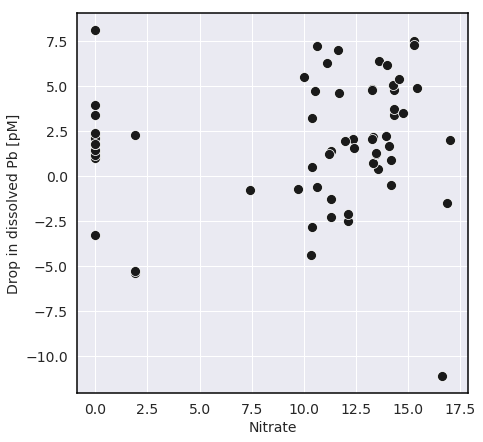

In [149]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
st = sns.axes_style("whitegrid")

with st:
#     sns.lineplot(xp, yp_pred, c='k')
    sns.scatterplot(drop_NO3, drop_Pb*1e3, color='k', s=100)
    
    ax.set_ylabel('Drop in dissolved Pb [pM]', fontsize=14)
    ax.set_xlabel('Nitrate', fontsize=14)
#     ax.set(ylim=(0,20.0), xlim=(0,20.0))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

In [9]:
dPb = np.concatenate((dPb_BB1, dPb_BB2, dPb_BB3, dPb_CAA1, dPb_CAA2, dPb_CAA3, dPb_CAA4, \
                      dPb_CAA5, dPb_CAA6, dPb_CAA7, dPb_CAA8, dPb_CAA9, dPb_CB1, dPb_CB2, \
                      dPb_CB3, dPb_CB4))
pPb = np.concatenate((pPb_BB1, pPb_BB2, pPb_BB3, pPb_CAA1, pPb_CAA2, pPb_CAA3, pPb_CAA4, \
                      pPb_CAA5, pPb_CAA6, pPb_CAA7, pPb_CAA8, pPb_CAA9, pPb_CB1, pPb_CB2, \
                      pPb_CB3, pPb_CB4))

In [10]:
dpb = dPb[(dPb*1e3 < 20) & (pPb < 20)]
ppb = pPb[(dPb*1e3 < 20) & (pPb < 20)]

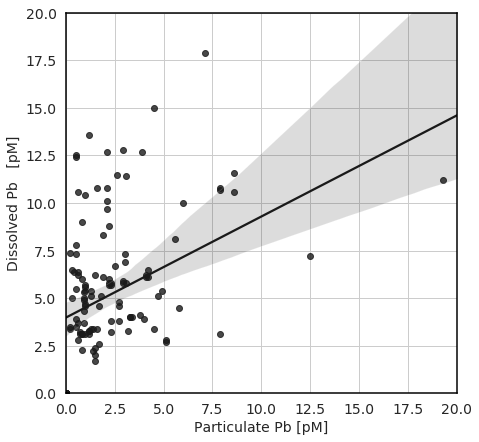

In [226]:
fig = plt.figure(figsize=(7,7))
st = sns.axes_style("whitegrid")

with st:
#     sns.lineplot(xp, yp_pred, c='k')
    ax = sns.regplot(ppb, dpb*1e3, scatter=True, robust=True, color='k')
    
    ax.set_ylabel('Dissolved Pb [pM]', fontsize=14)
    ax.set_xlabel('Particulate Pb [pM]', fontsize=14)
    ax.set(ylim=(0,20.0), xlim=(0,20.0))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

### Dissolved Pb vs. NO3 observations

In [116]:
NO3_leg2b = pd.read_csv('/ocean/brogalla/GEOTRACES/data/bio/NO3_data2.csv')
NO3_leg3a = pd.read_csv('/ocean/brogalla/GEOTRACES/data/bio/NO3_data3.csv')

In [117]:
lon_2b   = NO3_leg2b['Longitude [degrees_east]'].astype('float').values
lat_2b   = NO3_leg2b['Latitude [degrees_north]'].astype('float').values
depth_2b = NO3_leg2b['Depth [metres]'].astype('float').values
NO3_2b   = NO3_leg2b['NTRA_01 [mmol/m**3]'].astype('float').values

lon_3a   = NO3_leg3a['Longitude [degrees_east]'].astype('float').values
lat_3a   = NO3_leg3a['Latitude [degrees_north]'].astype('float').values
depth_3a = NO3_leg3a['Depth [metres]'].astype('float').values
NO3_3a   = NO3_leg3a['NTRA_01 [mmol/m^3]'].astype('float').values

In [118]:
lons_NO3 = np.append(lon_2b, lon_3a)
lats_NO3 = np.append(lat_2b, lat_3a)
dep_NO3  = np.append(depth_2b, depth_3a)
NO3_obs  = np.append(NO3_2b, NO3_3a)

In [130]:
stn_NO3 = np.empty_like(obs_lons)

for stn in range(0,len(obs_lons)):
    NO3_stn = NO3_obs[(np.abs(lons_NO3 - obs_lons[stn]) < 0.05) & (np.abs(lats_NO3 - obs_lats[stn]) < 0.05) & \
                      (np.abs(dep_NO3  - depths[stn])   < 1 )]
    
    NO3_stn[(NO3_stn < 1e-2)] = np.nan
    NO3_stn[(NO3_stn > 1e5)]  = np.nan
    
    # if there are multiple measurements of NO3 near this station at the depth:
    if (len(NO3_stn) > 0):
        stn_NO3[stn] = np.nanmean(NO3_stn, axis=0)

In [131]:
stn_NO3[stn_NO3 < 1] = np.nan

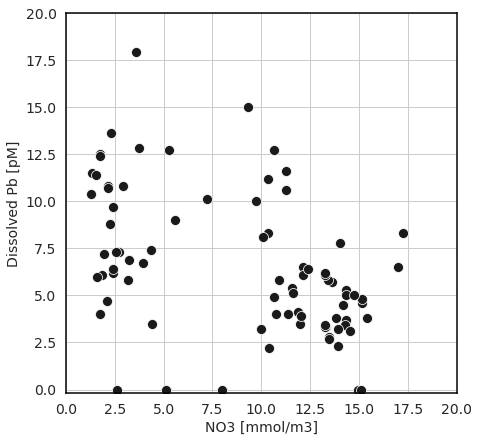

In [95]:
fig = plt.figure(figsize=(7,7))
st = sns.axes_style("whitegrid")

with st:
#     sns.lineplot(xp, yp_pred, c='k')
    ax = sns.scatterplot(stn_NO3, dPb*1e3, color='k', s=100)
    
    ax.set_ylabel('Dissolved Pb [pM]', fontsize=14)
    ax.set_xlabel('NO3 [mmol/m3]', fontsize=14)
    ax.set(ylim=(-0.2,20.0), xlim=(0,20.0))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

### Dissolved Pb vs. NO3 from CanOE output

In [110]:
folder= '/data/brogalla/bio/'
file  = 'NAA_730h_20100101_20101231_ptrc_T_no3.nc'

f1 = nc.Dataset(folder+file, 'r')

In [111]:
bio_lon  = np.array(f1.variables['nav_lon'])
bio_lat  = np.array(f1.variables['nav_lat'])
bio_dep  = np.array(f1.variables['deptht'])
bio_time = np.array(f1.variables['time_counter'])
NO3      = np.array(f1.variables['no3'])[8,:,:,:]

In [112]:
time_start = dt.datetime(2010,1,1)
bio_date   = [time_start + dt.timedelta(seconds=i) for i in bio_time]

In [113]:
bio_i = np.empty_like(lons)
bio_j = np.empty_like(lons)

for stn in range(0,len(stn_names)):
    i, j       = ar.find_closest_model_point(lons[stn], lats[stn], bio_lon, bio_lat, \
                                             tols={'NEMO': {'tol_lon': 0.2, 'tol_lat': 0.2}})
    bio_i[stn] = int(i)
    bio_j[stn] = int(j)

In [114]:
obs_bio_i = np.concatenate((np.ones(depth_BB1.shape)*bio_i[stn_names=='BB1'], \
                          np.ones(depth_BB2.shape)*bio_i[stn_names=='BB2'], \
                          np.ones(depth_BB3.shape)*bio_i[stn_names=='BB3'], \
                          np.ones(depth_CAA1.shape)*bio_i[stn_names=='CAA1'], \
                          np.ones(depth_CAA2.shape)*bio_i[stn_names=='CAA2'], \
                          np.ones(depth_CAA3.shape)*bio_i[stn_names=='CAA3'], \
                          np.ones(depth_CAA4.shape)*bio_i[stn_names=='CAA4'], \
                          np.ones(depth_CAA5.shape)*bio_i[stn_names=='CAA5'], \
                          np.ones(depth_CAA6.shape)*bio_i[stn_names=='CAA6'], \
                          np.ones(depth_CAA7.shape)*bio_i[stn_names=='CAA7'], \
                          np.ones(depth_CAA8.shape)*bio_i[stn_names=='CAA8'], \
                          np.ones(depth_CAA9.shape)*bio_i[stn_names=='CAA9'], \
                          np.ones(depth_CB1.shape)*bio_i[stn_names=='CB1'], \
                          np.ones(depth_CB2.shape)*bio_i[stn_names=='CB2'], \
                          np.ones(depth_CB3.shape)*bio_i[stn_names=='CB3'], \
                          np.ones(depth_CB4.shape)*bio_i[stn_names=='CB4']))

obs_bio_j = np.concatenate((np.ones(depth_BB1.shape)*bio_j[stn_names=='BB1'], \
                          np.ones(depth_BB2.shape)*bio_j[stn_names=='BB2'], \
                          np.ones(depth_BB3.shape)*bio_j[stn_names=='BB3'], \
                          np.ones(depth_CAA1.shape)*bio_j[stn_names=='CAA1'], \
                          np.ones(depth_CAA2.shape)*bio_j[stn_names=='CAA2'], \
                          np.ones(depth_CAA3.shape)*bio_j[stn_names=='CAA3'], \
                          np.ones(depth_CAA4.shape)*bio_j[stn_names=='CAA4'], \
                          np.ones(depth_CAA5.shape)*bio_j[stn_names=='CAA5'], \
                          np.ones(depth_CAA6.shape)*bio_j[stn_names=='CAA6'], \
                          np.ones(depth_CAA7.shape)*bio_j[stn_names=='CAA7'], \
                          np.ones(depth_CAA8.shape)*bio_j[stn_names=='CAA8'], \
                          np.ones(depth_CAA9.shape)*bio_j[stn_names=='CAA9'], \
                          np.ones(depth_CB1.shape)*bio_j[stn_names=='CB1'], \
                          np.ones(depth_CB2.shape)*bio_j[stn_names=='CB2'], \
                          np.ones(depth_CB3.shape)*bio_j[stn_names=='CB3'], \
                          np.ones(depth_CB4.shape)*bio_j[stn_names=='CB4']))

In [115]:
NO3_comp = np.empty_like(depths)

for i in range(0,len(depths)):
    ind         = np.argmin(np.abs(depths[i] - bio_dep))
    NO3_comp[i] = NO3[int(ind), int(obs_bio_i[i]), int(obs_bio_j[i])] # associated model depth 

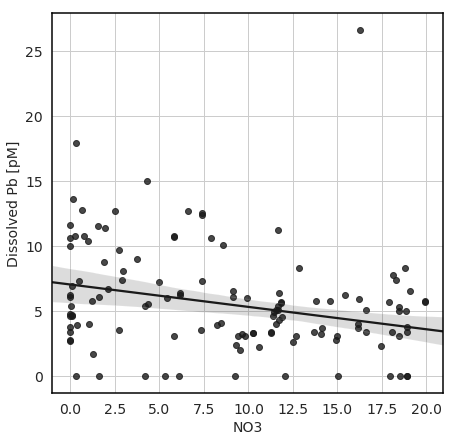

In [347]:
fig = plt.figure(figsize=(7,7))
st = sns.axes_style("whitegrid")

with st:
#     sns.lineplot(xp, yp_pred, c='k')
    ax = sns.regplot(NO3_comp, dPb*1e3, scatter=True, robust=True, color='k')
    
    ax.set_ylabel('Dissolved Pb [pM]', fontsize=14)
    ax.set_xlabel('NO3', fontsize=14)
#     ax.set(ylim=(0,20.0), xlim=(0,20.0))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    